In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import warnings

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
def fetch_stock_data(ticker, period="5y"):

    data = yf.download(ticker, period=period, progress=False)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

In [ ]:
def calculate_technical_indicators(df):

    data = df.copy()

    # Simple Moving Average (10-day)
    data['SMA_10'] = data['Close'].rolling(window=10).mean()

    # Exponential Moving Average (20-day)
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

    # Relative Strength Index (14-day)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI_14'] = 100 - (100 / (1 + rs))

    data.dropna(inplace=True)

    return data

In [ ]:
def create_sequences(data, seq_length=60):

    X, y = [], []

    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Past 60 days
        y.append(data[i, 3])  # Next day's Close

    return np.array(X), np.array(y)

In [ ]:
def prepare_data(df, seq_length=60, train_split=0.8):

    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'EMA_20', 'RSI_14']
    data = df[feature_cols].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = create_sequences(scaled_data, seq_length)

    split_idx = int(len(X) * train_split)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train)
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test)

    train_dataset = TensorDataset(X_train_t, y_train_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, scaler, feature_cols, X_test, y_test

In [ ]:
class StockLSTM(nn.Module):

    def __init__(self, input_size=8, hidden_size=64, num_layers=2, dropout=0.2):
        super(StockLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=50, device='cpu'):

    model.to(device)
    model.train()

    train_losses = []

    print("\n" + "="*50)
    print("TRAINING STARTED")
    print("="*50)

    for epoch in range(num_epochs):
        epoch_loss = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

    print("="*50)
    print("TRAINING COMPLETED")
    print("="*50 + "\n")

    return train_losses

In [ ]:
def evaluate_model(model, test_loader, scaler, X_test, y_test, device='cpu'):

    model.to(device)
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch)
            predictions.extend(pred.squeeze().cpu().numpy())
            actuals.extend(y_batch.numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)


    dummy = np.zeros((len(predictions), scaler.n_features_in_))
    dummy[:, 3] = predictions
    predictions_inv = scaler.inverse_transform(dummy)[:, 3]

    dummy[:, 3] = actuals
    actuals_inv = scaler.inverse_transform(dummy)[:, 3]

    mse = mean_squared_error(actuals_inv, predictions_inv)
    r2 = r2_score(actuals_inv, predictions_inv)

    print("="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print("="*50 + "\n")

    return predictions_inv, actuals_inv, mse, r2

In [ ]:
def predict_next_close(model, data, scaler, seq_length=60, device='cpu'):

    model.to(device)
    model.eval()

    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'EMA_20', 'RSI_14']
    last_sequence = data[feature_cols].values[-seq_length:]

    last_sequence_scaled = scaler.transform(last_sequence)

    input_tensor = torch.FloatTensor(last_sequence_scaled).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction_scaled = model(input_tensor).cpu().numpy()[0][0]

    dummy = np.zeros((1, scaler.n_features_in_))
    dummy[0, 3] = prediction_scaled
    predicted_price = scaler.inverse_transform(dummy)[0, 3]

    return predicted_price


In [ ]:
#visualisation
def plot_results(actuals, predictions, ticker):

    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label='Actual Price', color='blue', linewidth=2)
    plt.plot(predictions, label='Predicted Price', color='red', linestyle='--', linewidth=2)
    plt.title(f'{ticker} - Actual vs Predicted Closing Prices', fontsize=16, fontweight='bold')
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Price (INR)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_training_loss(losses):

    plt.figure(figsize=(10, 5))
    plt.plot(losses, color='green', linewidth=2)
    plt.title('Training Loss Over Epochs', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Using device: cpu



/tmp/ipython-input-1285708808.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, progress=False)



Model Architecture:
StockLSTM(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Total parameters: 52289


TRAINING STARTED
Epoch [1/50], Loss: 0.122624
Epoch [10/50], Loss: 0.002493
Epoch [20/50], Loss: 0.001783
Epoch [30/50], Loss: 0.001563
Epoch [40/50], Loss: 0.001402
Epoch [50/50], Loss: 0.001237
TRAINING COMPLETED

EVALUATION RESULTS
Mean Squared Error (MSE): 3108.04
R² Score: 0.9629

FUTURE PREDICTION
Predicted next closing price: ₹3315.33
Last known closing price: ₹3319.00
Predicted change: ₹-3.67 (-0.11%)



/tmp/ipython-input-2842943702.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(df['Close'].iloc[-1])


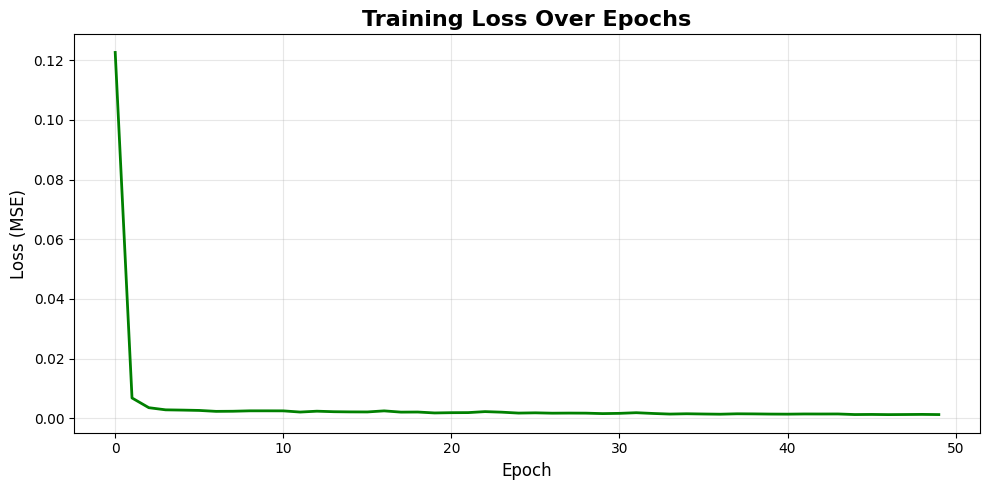

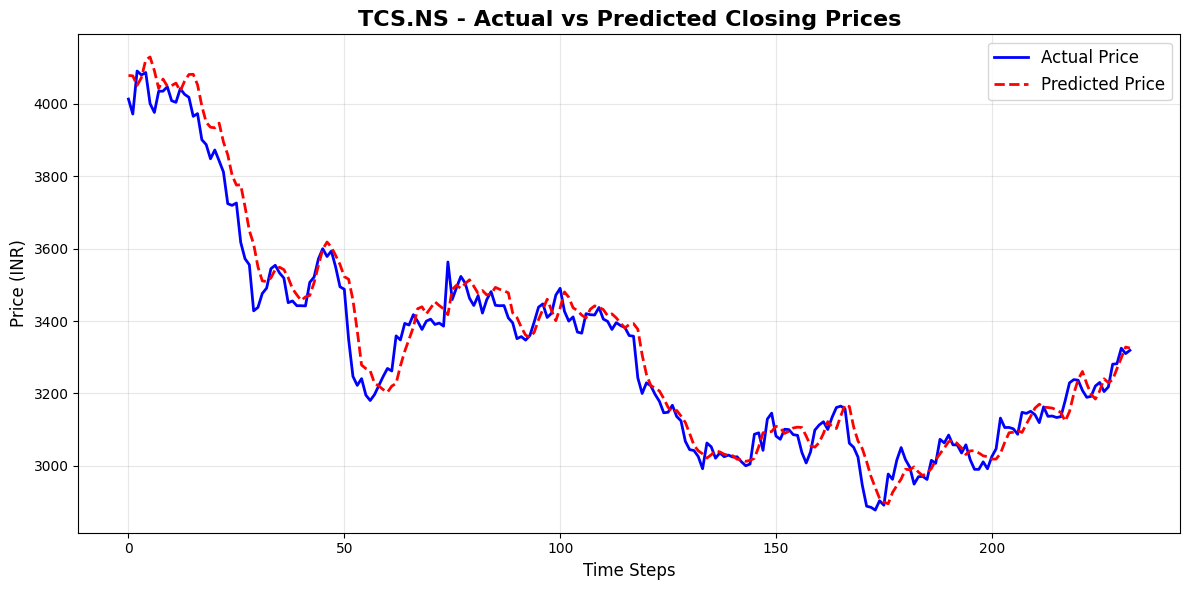


PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
def main():


    TICKER = "TCS.NS"  # tcs
    SEQ_LENGTH = 60
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f"Using device: {DEVICE}")
    print("="*50 + "\n")

    df = fetch_stock_data(TICKER)
    df = calculate_technical_indicators(df)

    train_loader, test_loader, scaler, feature_cols, X_test, y_test = prepare_data(
        df, seq_length=SEQ_LENGTH
    )

    input_size = len(feature_cols)
    model = StockLSTM(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.2)

    print(f"\nModel Architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}\n")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = train_model(
        model, train_loader, criterion, optimizer,
        num_epochs=NUM_EPOCHS, device=DEVICE
    )

    predictions, actuals, mse, r2 = evaluate_model(
        model, test_loader, scaler, X_test, y_test, device=DEVICE
    )

    next_price = predict_next_close(model, df, scaler, seq_length=SEQ_LENGTH, device=DEVICE)
    last_close = float(df['Close'].iloc[-1])
    price_change = next_price - last_close
    percent_change = ((next_price / last_close) - 1) * 100

    print("="*50)
    print("FUTURE PREDICTION")
    print("="*50)
    print(f"Predicted next closing price: ₹{next_price:.2f}")
    print(f"Last known closing price: ₹{last_close:.2f}")
    print(f"Predicted change: ₹{price_change:.2f} ({percent_change:+.2f}%)")
    print("="*50 + "\n")

    plot_training_loss(train_losses)
    plot_results(actuals, predictions, TICKER)

    print("\n" + "="*50)
    print("PIPELINE COMPLETED SUCCESSFULLY")
    print("="*50)

    return model, scaler, df


if __name__ == "__main__":
    model, scaler, data = main()